In [1]:
# Genre Prediction
import os
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
from tensorflow.keras.preprocessing.image import load_img, img_to_array,ImageDataGenerator
from tensorflow.keras import layers,Model

In [2]:
imageDirectory = 'poster_images/'
imdb_df = pd.read_csv('finalIMDB.csv')
imdb_df.rename(columns={'Unnamed: 0':'IMDb_ID'},inplace=True)
imdb_df.head()

,IMDb_ID,Poster_Link,Series_Title,Released_Year,Certificate,Runtime,Genre,IMDB_Rating,Overview,Meta_score,Director,Star1,Star2,Star3,Star4,No_of_Votes,Gross,IMDb_ID
0,0,https://m.media-amazon.com/images/M/MV5BMDFkYT...,The Shawshank Redemption,1994,A,142 min,Drama,9.3,Two imprisoned men bond over a number of years...,80.0,Frank Darabont,Tim Robbins,Morgan Freeman,Bob Gunton,William Sadler,2343110,"28,341,469",tt0000001
1,1,https://m.media-amazon.com/images/M/MV5BM2MyNj...,The Godfather,1972,A,175 min,"Crime, Drama",9.2,An organized crime dynasty's aging patriarch t...,100.0,Francis Ford Coppola,Marlon Brando,Al Pacino,James Caan,Diane Keaton,1620367,"134,966,411",tt0000002
2,2,https://m.media-amazon.com/images/M/MV5BMTMxNT...,The Dark Knight,2008,UA,152 min,"Action, Crime, Drama",9.0,When the menace known as the Joker wreaks havo...,84.0,Christopher Nolan,Christian Bale,Heath Ledger,Aaron Eckhart,Michael Caine,2303232,"534,858,444",tt0000003
3,3,https://m.media-amazon.com/images/M/MV5BMWMwMG...,The Godfather: Part II,1974,A,202 min,"Crime, Drama",9.0,The early life and career of Vito Corleone in ...,90.0,Francis Ford Coppola,Al Pacino,Robert De Niro,Robert Duvall,Diane Keaton,1129952,"57,300,000",tt0000004
4,4,https://m.media-amazon.com/images/M/MV5BMWU4N2...,12 Angry Men,1957,U,96 min,"Crime, Drama",9.0,A jury holdout attempts to prevent a miscarria...,96.0,Sidney Lumet,Henry Fonda,Lee J. Cobb,Martin Balsam,John Fiedler,689845,"4,360,000",tt0000005


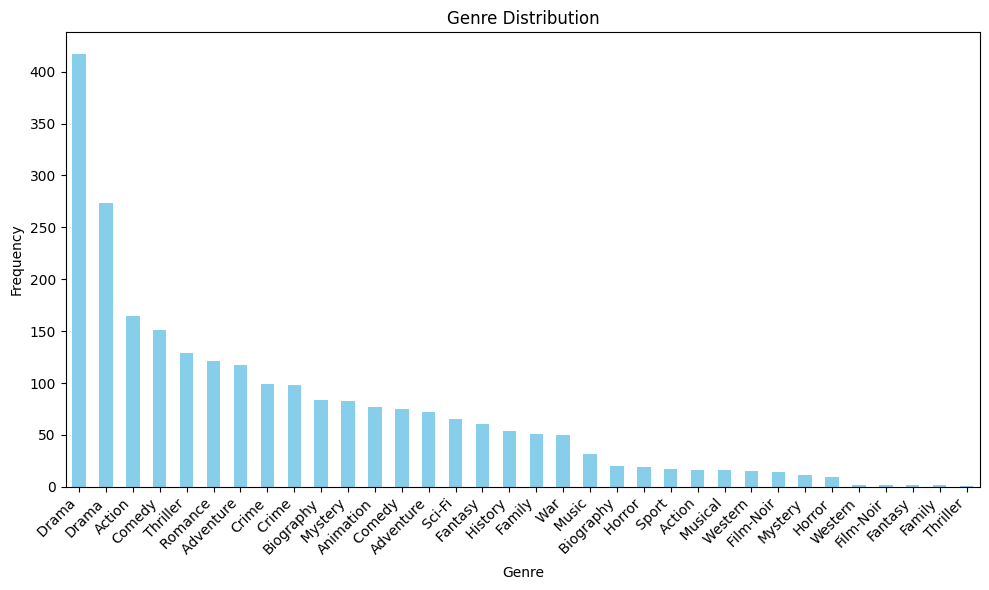

In [3]:
genre_counts = imdb_df['Genre'].str.strip().str.split(',', expand=True).stack().value_counts()
plt.figure(figsize=(10, 6))
genre_counts.plot(kind='bar', color='skyblue')
plt.title('Genre Distribution')
plt.xlabel('Genre')
plt.ylabel('Frequency')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [4]:
multiclassBinarizer = MultiLabelBinarizer()
labels = multiclassBinarizer.fit_transform(imdb_df['Genre'].str.split(','))
imageIds = imdb_df['IMDb_ID']
num_classes = len(multiclassBinarizer.classes_)
print(num_classes)

34


In [5]:
image_dir = 'poster_images/'

image_paths = [os.path.join(image_dir, filename) for filename in os.listdir(image_dir) if filename.endswith('.jpg')]

input_images = []
for image_path in image_paths:
    img = load_img(image_path, target_size=(150, 150))
    img_array = img_to_array(img)
    input_images.append(img_array)

input_images = np.array(input_images) / 255.0

print("Data Type:", input_images.dtype)
print("Data Shape:", input_images.shape)

Data Type: float32
Data Shape: (951, 150, 150, 3)


In [6]:
X_train,X_test,y_train,y_test = train_test_split(input_images, labels, test_size=0.1)


In [7]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True
)

test_datagen = ImageDataGenerator(rescale=1./255)

In [8]:
model = tf.keras.Sequential([
    layers.Conv2D(32, (3,3), activation='relu', input_shape=input_images[0].shape),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2,2)),
    layers.Dropout(0.3),

    layers.Conv2D(64, (3,3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2,2)),
    layers.Dropout(0.3),
    

    # layers.Conv2D(128, (3,3), activation='relu'),
    # layers.BatchNormalization(),
    # layers.MaxPooling2D((2,2)),
    # layers.Dropout(0.4),
    
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    # layers.Dense(128,activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    layers.Dense(34, activation='softmax')
])

model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

In [9]:
# train_images, test_images, train_labels, test_labels = train_test_split(input_images, labels, test_size=0.2, random_state=42)

# train_images, val_images, train_labels, val_labels = train_test_split(train_images, train_labels, test_size=0.2, random_state=42)

# history = model.fit(
#     X_train,  # Input images for training
#     y_train,  # Corresponding labels for training images
#     epochs=5,  # Adjust batch size as needed
#     validation_data=(X_test, y_test)  # Validation data
# )

# test_loss, test_acc = model.evaluate(test_images, test_labels)
# print(f'Test accuracy: {test_acc}')

train_images, val_images, train_labels, val_labels = train_test_split(input_images, labels, test_size=0.1)
history = model.fit(
    train_datagen.flow(train_images, train_labels, batch_size=16),
    steps_per_epoch=len(train_images) // 16,
    epochs=10,
    validation_data=(val_images, val_labels)
)

Epoch 1/10


53/53 [==============================] - 35s 603ms/step - loss: 10.1822 - accuracy: 0.0369 - val_loss: 10.2628 - val_accuracy: 0.0521
Epoch 2/10
53/53 [==============================] - 30s 557ms/step - loss: 9.6510 - accuracy: 0.0441 - val_loss: 9.3359 - val_accuracy: 0.0104
Epoch 3/10
36/53 [===================>..........] - ETA: 9s - loss: 9.3312 - accuracy: 0.0847

: 